In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [27]:
trainData = pd.read_csv('train_data.csv')
result = pd.read_csv('results.csv')
trainData.head(10)

id  acousticness  danceability  energy explicit  instrumentalness  key  \
0   2015         0.949         0.235  0.0276       No           0.92700    5   
1  15901         0.855         0.456  0.4850       No           0.08840    4   
2   9002         0.827         0.495  0.4990       No           0.00000    0   
3   6734         0.654         0.643  0.4690       No           0.10800    7   
4  15563         0.738         0.705  0.3110       No           0.00000    5   
5  14384         0.898         0.498  0.4420       No           0.00319   10   
6    954         0.259         0.620  0.7580       No           0.00132    5   
7   5930         0.124         0.879  0.6280      Yes           0.00000    1   
8  11900         0.149         0.697  0.1840      Yes           0.00000    2   
9  14498         0.470         0.587  0.5660       No           0.00000    9   

   liveness  loudness   mode release_date  speechiness    tempo  valence  \
0    0.5130   -27.398  Major   01-01-1947       0.0381  110.838   0.0398   
1    0.1510   -10.046  Major   13-11-2020       0.0437  152.066   0.8590   
2    0.4010    -8.009  Minor   01-01-1950       0.0474  108.004   0.7090   
3    0.2180   -15.917  Major   30-04-1974       0.0368   83.636   0.9640   
4    0.3220   -12.344  Major   01-01-1973       0.0488  117.260   0.7850   
5    0.0974    -9.481  Major   01-01-1968       0.0337  109.619   0.3550   
6    0.4160    -8.183  Major   13-11-1942       0.0343  119.258   0.9120   
7    0.0661    -6.668  Minor   01-01-2005       0.2640  150.105   0.7210   
8    0.0763   -23.303  Minor   01-01-1945       0.9330  133.997   0.6130   
9    0.0644    -9.932  Major   01-01-1999       0.0276   76.054   0.5290   

   year  duration-min popularity  
0  1947           3.0   very low  
1  2020           2.4        low  
2  1950           2.6   very low  
3  1974           2.4        low  
4  1973           3.4    average  
5  1968           2.6        low  
6  1942           2.4   very low  
7  2005           3.5    average  
8  1945           1.6   very low  
9  1999           7.7       high

In [7]:
def check_duplicates(df):
    print('\n----------------------------------')
    print('Printing all duplicate fields :: \n')
    duplicates = df.duplicated()
    print(duplicates)
    print('\n processing duplicates  ::   ok')
    print('----------------------------------\n')


def check_missing(df):
    
    print('\n----------------------------------')
    print('Printing number of missing fields ::  \n')
    print(df.isnull().sum())
    print('\n processing missing values ::  ok')
    print('----------------------------------\n')
    

def check_shape(df):
    print('\n----------------------------------')
    print('The size and shape of the training data is given as follows :: \n' )
    print('No. of data points  :' + str(df.shape[0]) +'\n No of features :' + str(df.shape[1]-2))
    print('Total shape  :' + str(df.shape)+'\n')
    print('----------------------------------\n')


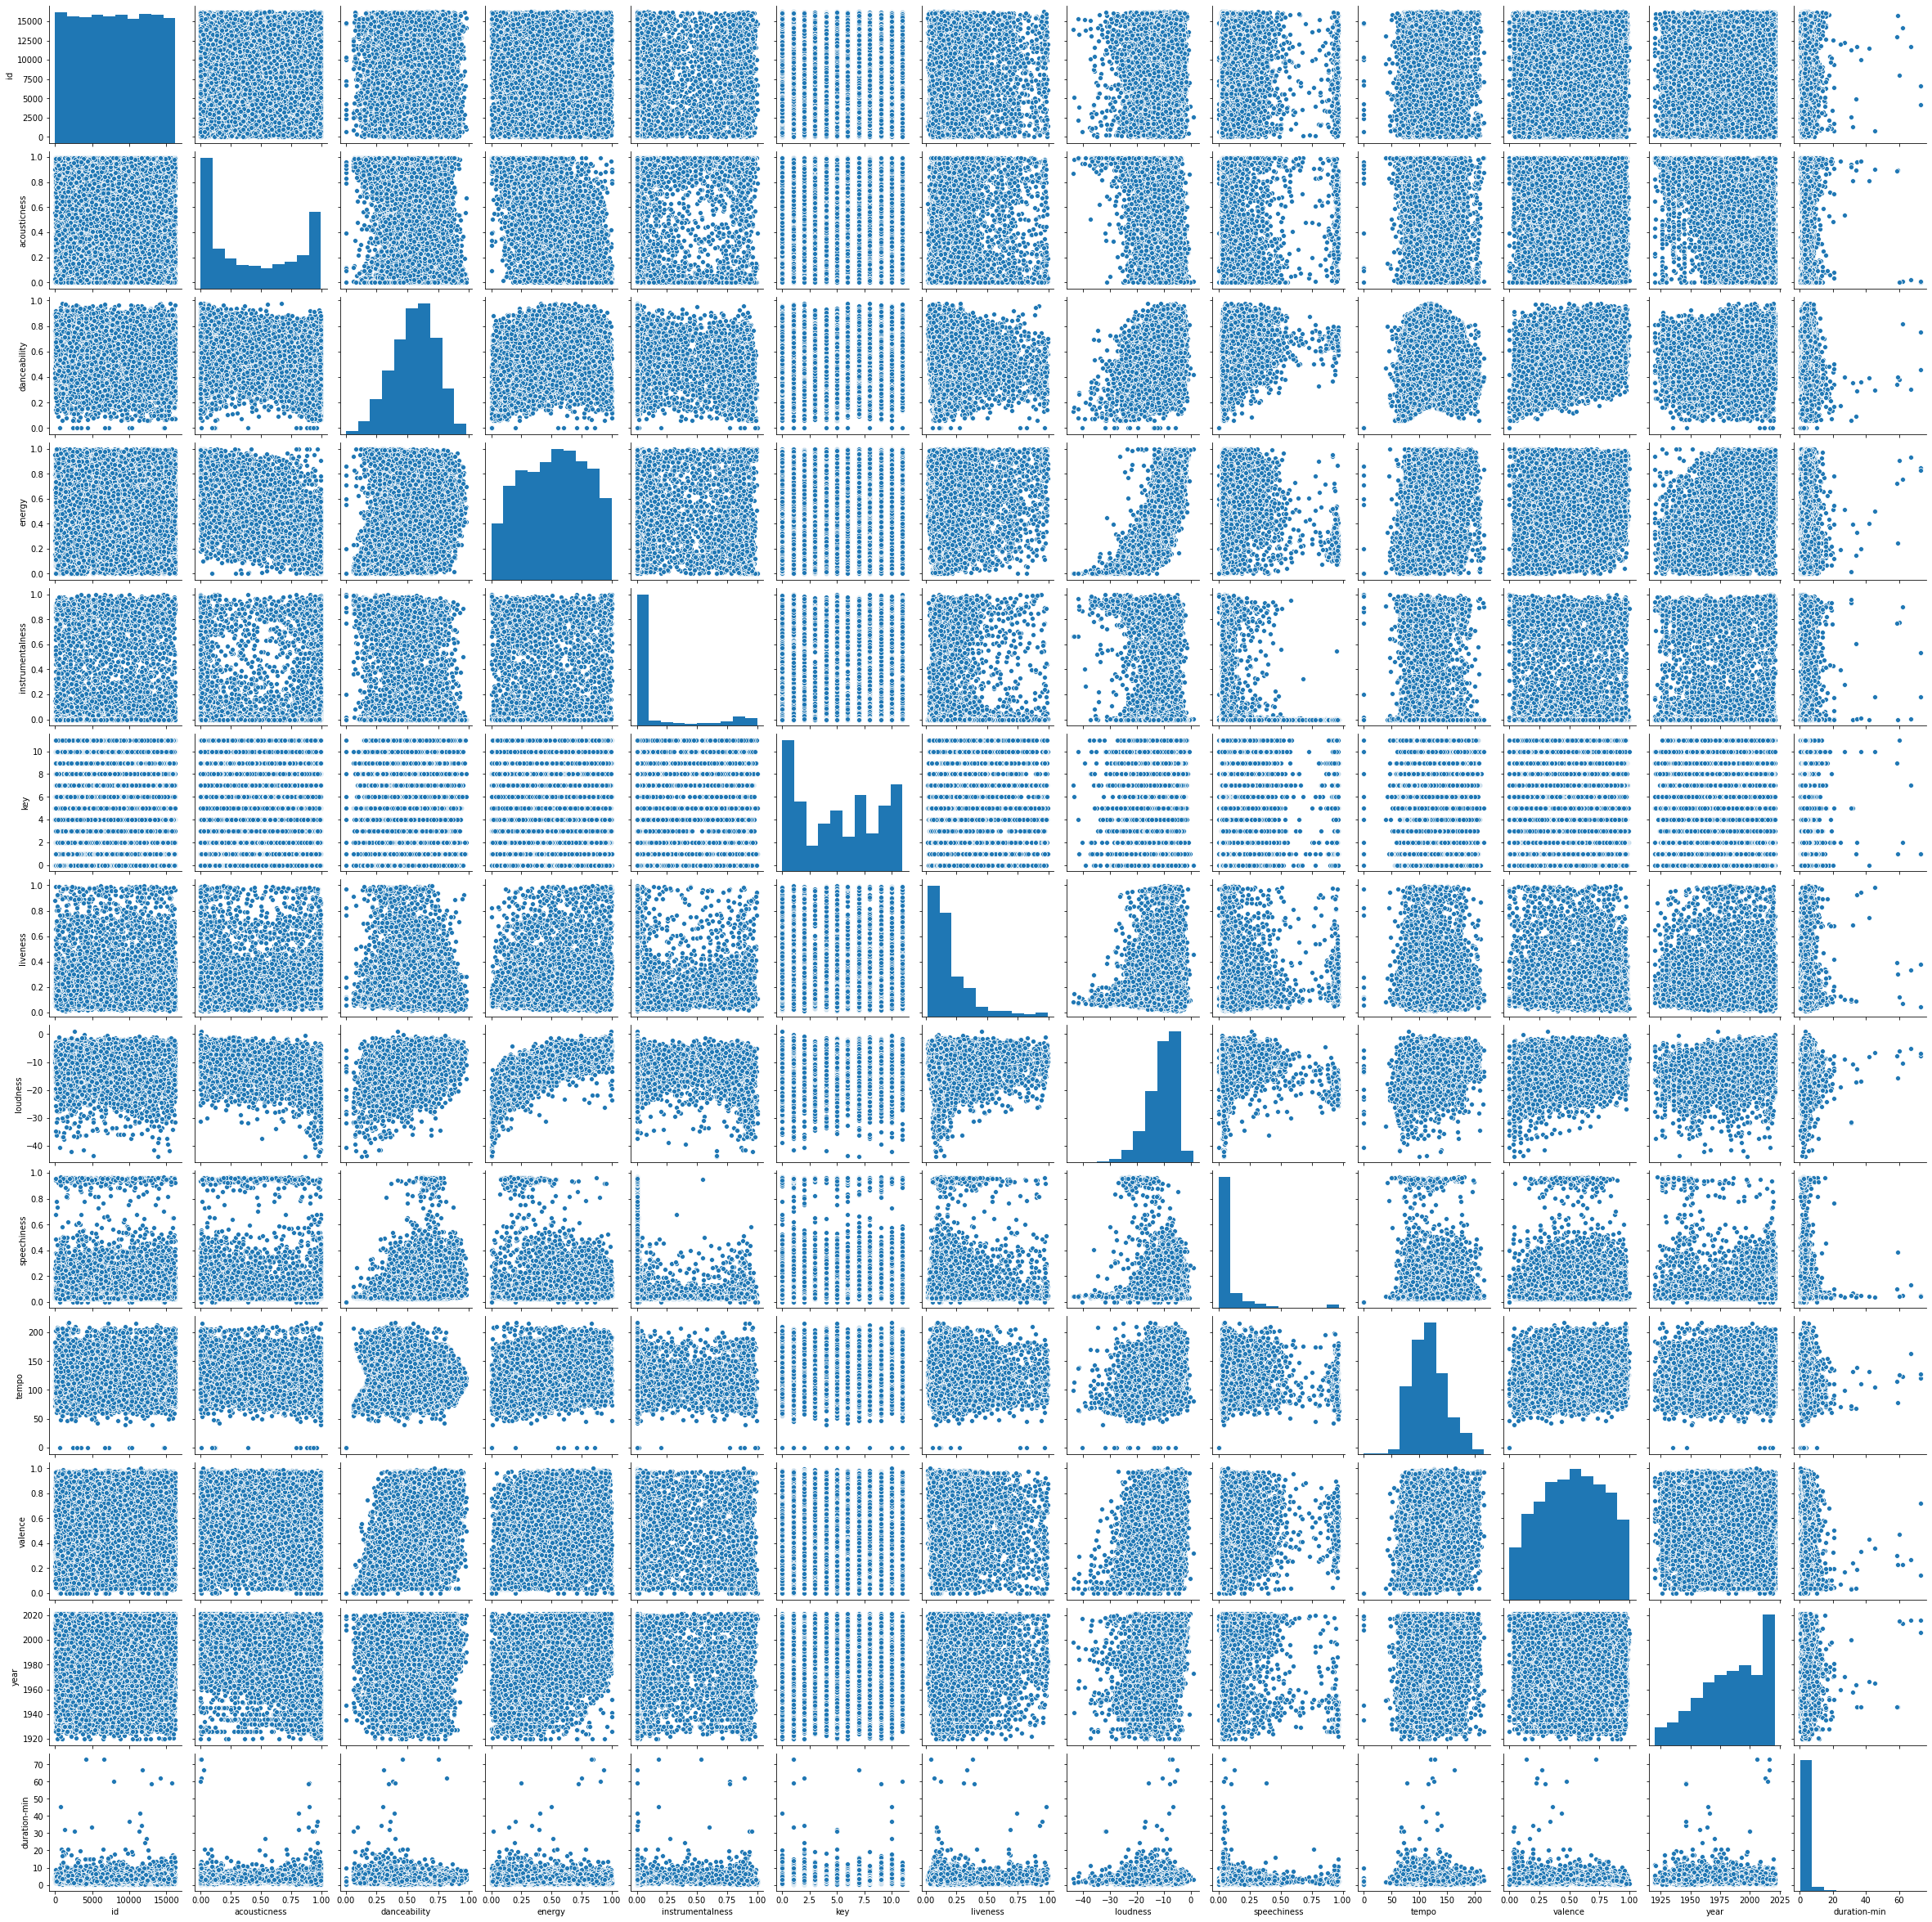

In [28]:
sns.pairplot(trainData)

In [8]:
check_shape(trainData)
check_missing(trainData)
check_duplicates(trainData)


----------------------------------
The size and shape of the training data is given as follows :: 

No. of data points  :12227
 No of features :15
Total shape  :(12227, 17)

----------------------------------


----------------------------------
Printing number of missing fields ::  

id                  0
acousticness        0
danceability        0
energy              0
explicit            0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
duration-min        0
popularity          0
dtype: int64

 processing missing values ::  ok
----------------------------------


----------------------------------
Printing all duplicate fields :: 

0        False
1        False
2        False
3        False
4        False
         ...  
12222    False
12223    False
12224    False
12225    False
12226    False
Length: 12227, dtyp

In [9]:
def one_hot_encoding(dataframe,features):

    for f in features: 
        df = dataframe[[f]]

        df2 = (pd.get_dummies(df, prefix='', prefix_sep='')
                   .max(level=0, axis=1)
                   .add_prefix(f+' - '))  
        dataframe = pd.concat([dataframe, df2], axis=1)
        dataframe = dataframe.drop([f], axis=1) 
    return dataframe

tonumeric = {'very low' : 1,
             'low' : 2,
             'average' : 3,
             'high' : 4,
            'very high' : 5}

trainData['popularity'] = trainData['popularity'].map(tonumeric)

trainData['age'] = 2021 - trainData['year']

encoding_fs = ['explicit', 'mode']

trainData = one_hot_encoding(trainData, encoding_fs)

trainData.head()

id  acousticness  danceability  energy  instrumentalness  key  liveness  \
0   2015         0.949         0.235  0.0276            0.9270    5     0.513   
1  15901         0.855         0.456  0.4850            0.0884    4     0.151   
2   9002         0.827         0.495  0.4990            0.0000    0     0.401   
3   6734         0.654         0.643  0.4690            0.1080    7     0.218   
4  15563         0.738         0.705  0.3110            0.0000    5     0.322   

   loudness release_date  speechiness    tempo  valence  year  duration-min  \
0   -27.398   01-01-1947       0.0381  110.838   0.0398  1947           3.0   
1   -10.046   13-11-2020       0.0437  152.066   0.8590  2020           2.4   
2    -8.009   01-01-1950       0.0474  108.004   0.7090  1950           2.6   
3   -15.917   30-04-1974       0.0368   83.636   0.9640  1974           2.4   
4   -12.344   01-01-1973       0.0488  117.260   0.7850  1973           3.4   

   popularity  age  explicit - No  explicit - Yes  mode - Major  mode - Minor  
0           1   74              1               0             1             0  
1           2    1              1               0             1             0  
2           1   71              1               0             0             1  
3           2   47              1               0             1             0  
4           3   48              1               0             1             0

In [10]:
categoricalmeans = trainData.groupby(['popularity']).mean()
print(categoricalmeans)

                     id  acousticness  danceability    energy  \
popularity                                                      
1           7938.987585      0.675366      0.520676  0.382525   
2           8181.341244      0.433729      0.524569  0.515177   
3           8125.903503      0.330648      0.566693  0.585875   
4           8116.171144      0.258232      0.610257  0.620920   
5           8302.289973      0.272311      0.674146  0.599090   

            instrumentalness       key  liveness   loudness  speechiness  \
popularity                                                                 
1                   0.301623  5.173495  0.222676 -13.562435     0.152748   
2                   0.149813  5.125080  0.215004 -11.731436     0.068724   
3                   0.092348  5.259959  0.186065  -9.537759     0.072384   
4                   0.043484  5.249424  0.180237  -7.631583     0.091318   
5                   0.012360  5.414634  0.169975  -6.795092     0.106060   

           

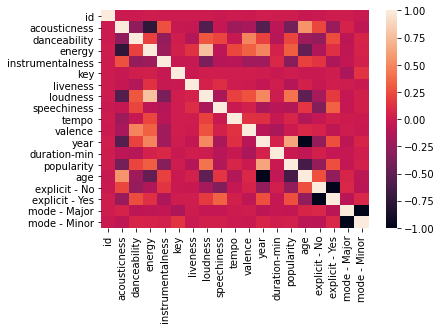

In [11]:
sns.heatmap(trainData.corr())

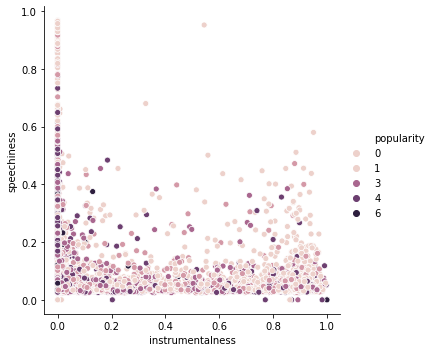

In [12]:
sns.relplot(data = trainData, x = 'instrumentalness', y = 'speechiness', hue = 'popularity')

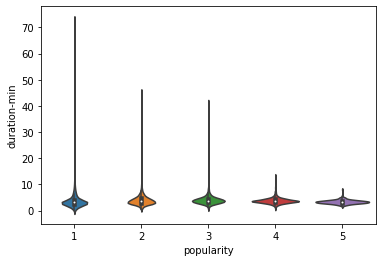

In [13]:
sns.violinplot(data = trainData, x = 'popularity', y = 'duration-min')

In [14]:
trainData['bang'] = trainData['energy']*trainData['loudness']*trainData['tempo']
bang_scaling_factor = (trainData['bang'].max()-trainData['bang'].min())
trainData['bang'] = trainData['bang']/bang_scaling_factor
trainData['happiness'] = trainData['danceability']*trainData['valence']*trainData['energy']
happiness_scaling_factor = trainData['happiness'].max() - trainData['happiness'].min()
trainData['happiness'] = trainData['happiness']/happiness_scaling_factor
trainData['pop_tempo'] = pow((120 - trainData['tempo']),2)/1000
trainData['rap_tempo'] = pow((90 - trainData['tempo'] ),2)/1000
trainData['metal_tempo'] = pow(170 - trainData['tempo'],2 )/1000
trainData['g0'] = (1+trainData['acousticness'])*(1+trainData['instrumentalness'])/(1+(trainData['energy'])*(1+trainData['tempo'])*(1+trainData['valence']))
trainData['g1'] = (1+trainData['instrumentalness'])*(1+trainData['valence'])/((1+trainData['acousticness'])*(1+trainData['speechiness']))
trainData['g2'] = (1+trainData['instrumentalness'])/((1+trainData['speechiness'])*(1+trainData['valence']))
trainData['g3'] = (1+trainData['valence'])*(1+trainData['speechiness'])/(1+trainData['instrumentalness'])
trainData['g4'] = (1+trainData['instrumentalness'])*(1+trainData['danceability'])*(1+trainData['tempo'])/(1+trainData['acousticness'])
trainData['g5'] = (1+trainData['energy'])*(1+trainData['valence'])*(1+trainData['tempo'])/((1+trainData['acousticness'])*(1+trainData['instrumentalness']))
trainData['g6'] = (1+trainData['acousticness'])*(1+trainData['danceability'])*(1+trainData['speechiness'])/(1+trainData['energy'])
trainData['g7'] = (1+trainData['valence'])*(1+trainData['instrumentalness'])/((1+trainData['tempo'])*(1+trainData['speechiness']))
trainData['g8'] = (1+trainData['energy'])*(1+trainData['tempo'])*(1+trainData['instrumentalness'])/((1+trainData['acousticness'])*(1+trainData['speechiness']))
trainData['time_deviation'] = pow((3.4 - trainData['duration-min']),2)
trainData.head()

id  acousticness  danceability  energy  instrumentalness  key  liveness  \
0   2015         0.949         0.235  0.0276            0.9270    5     0.513   
1  15901         0.855         0.456  0.4850            0.0884    4     0.151   
2   9002         0.827         0.495  0.4990            0.0000    0     0.401   
3   6734         0.654         0.643  0.4690            0.1080    7     0.218   
4  15563         0.738         0.705  0.3110            0.0000    5     0.322   

   loudness release_date  speechiness  ...        g0        g1        g2  \
0   -27.398   01-01-1947       0.0381  ...  0.892185  0.990331  1.785224   
1   -10.046   13-11-2020       0.0437  ...  0.014524  1.045077  0.560962   
2    -8.009   01-01-1950       0.0474  ...  0.019445  0.893081  0.558657   
3   -15.917   30-04-1974       0.0368  ...  0.023210  1.268968  0.544131   
4   -12.344   01-01-1973       0.0488  ...  0.026076  0.979255  0.534157   

         g3          g4          g5        g6        g7          g8  \
0  0.560154  136.560854   31.817771  2.431610  0.017258  109.457159   
1  1.782652  130.762955  209.291760  1.898255  0.012665  127.783307   
2  1.790007   89.195939  152.843714  1.908493  0.014969   85.387235   
3  1.837794   93.153022  133.242614  1.917990  0.024799   80.331558   
4  1.872108  116.014557  159.231510  2.370632  0.014392   85.054661   

   time_deviation  
0            0.16  
1            1.00  
2            0.64  
3            1.00  
4            0.00  

[5 rows x 35 columns]

In [15]:


X_trainK = trainData
del X_trainK['popularity']

In [16]:
trainData.nunique(axis = 0)

id                  12227
acousticness         2714
danceability          898
energy               1396
instrumentalness     3658
key                    12
liveness             1477
loudness             8718
release_date         3859
speechiness          1275
tempo               11264
valence              1256
year                  102
duration-min          172
age                   102
explicit - No           2
explicit - Yes          2
mode - Major            2
mode - Minor            2
bang                12162
happiness           12151
pop_tempo           10826
rap_tempo           10982
metal_tempo         11211
g0                  12175
g1                  12173
g2                  12153
g3                  12153
g4                  12175
g5                  12175
g6                  12174
g7                  12172
g8                  12175
time_deviation        158
dtype: int64

In [17]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(np.array(X_trainK))

ValueError: could not convert string to float: '24-07-2020'

In [18]:
kmeans.cluster_centers_

NameError: name 'kmeans' is not defined

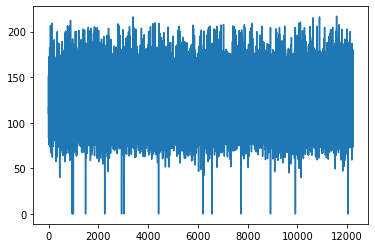

In [19]:
tempoline = trainData['tempo']
np.array(tempoline)
sns.lineplot(data = tempoline)

In [20]:
trainData['danceability'].mean()

0.5563526539625426

In [21]:
trainData['danceability'].stdev()

AttributeError: 'Series' object has no attribute 'stdev'

In [22]:
result_table  = result.groupby('popularity').count()

In [23]:
print(result_table)

              id
popularity      
average      907
high         707
low         1205
very high     11
very low    1170


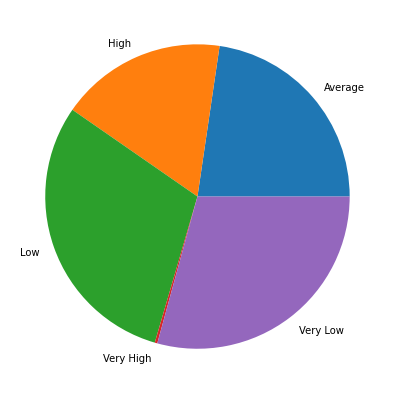

In [26]:

pops = ['Average', 'High', 'Low', 'Very High', 'Very Low']

# Creating plot 
fig = plt.figure(figsize =(10, 7))

plt.pie(result_table['id'], labels = pops ) 
  
# show plot 
plt.show() 

In [31]:
def revenue_calculator(predicted,y_act):
    total_profit = 0
    total_cost = 0
    successful_bids = 0
    max_profit = 0
    for i in range(len(predicted)):
        if predicted[i] >= y_act[i]:
            total_profit += 2*y_act[i] - predicted[i]
            total_cost += predicted[i]
            successful_bids += 1
            max_profit += y_act[i]
    print(total_profit)
    print(total_cost)
    print(successful_bids)
    print(max_profit)
    
preds = np.array([1,2,3,4,5])
yact = np.array([2,2,2,2,2])
    
revenue_calculator(preds, yact)
    
    

2
14
4


TypeError: pie() got an unexpected keyword argument 'fontsize'

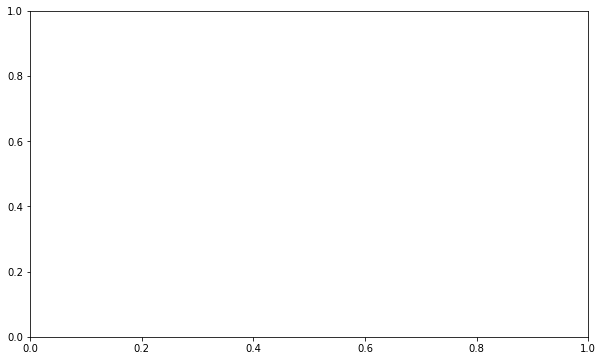

In [32]:
#Using matplotlib
pie, ax = plt.subplots(figsize=[10,6])
labels = pops
plt.pie(x=result_table, autopct="%.1f%%",  labels=labels, pctdistance=0.5, fontsize = 10)
plt.title("Popularity labels", fontsize=14);
pie.savefig("PopularityCHart.png")

<Figure size 4800x3600 with 0 Axes>

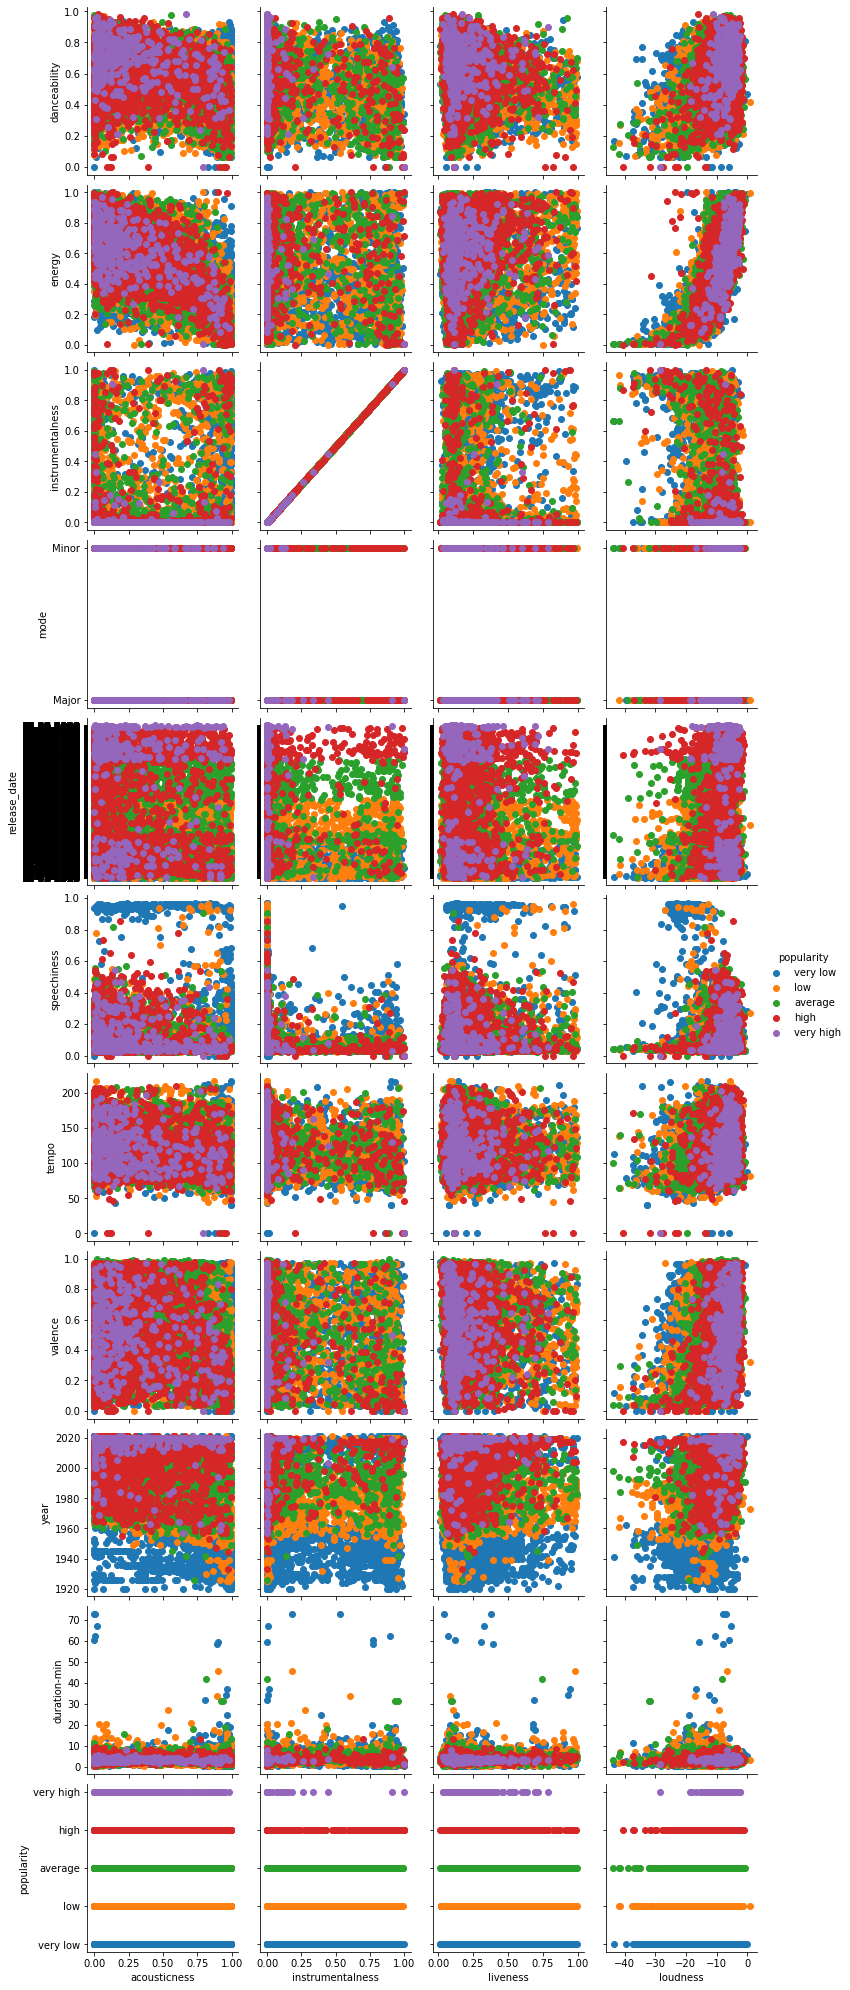

In [33]:
plt.figure( figsize=(8,6), dpi= 600)

data_grid = sns.PairGrid(trainData, hue='popularity', x_vars=[ 'acousticness',
       'instrumentalness', 'liveness', 'loudness'], y_vars=['danceability', 'energy', 
       'instrumentalness', 'mode',
       'release_date', 'speechiness', 'tempo', 'valence', 'year',
       'duration-min', 'popularity'])

data_grid.map(plt.scatter)
data_grid.add_legend()

<Figure size 600x1500 with 0 Axes>

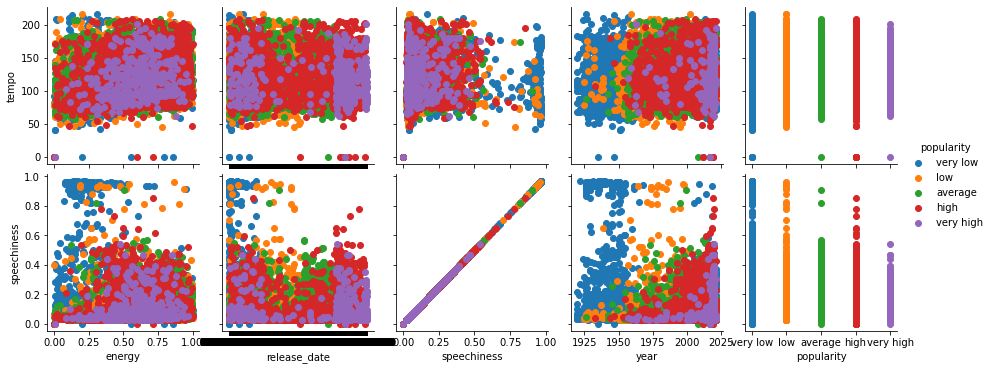

In [37]:
plt.figure( figsize=(2,5), dpi= 300)

data_grid = sns.PairGrid(trainData, hue='popularity', y_vars=[ 'tempo', 'speechiness'], x_vars=[ 'energy', 'release_date', 'speechiness', 'year','popularity'])

data_grid.map(plt.scatter)
data_grid.add_legend()

KeyError: "['duration_min'] not in index"

<Figure size 600x600 with 0 Axes>

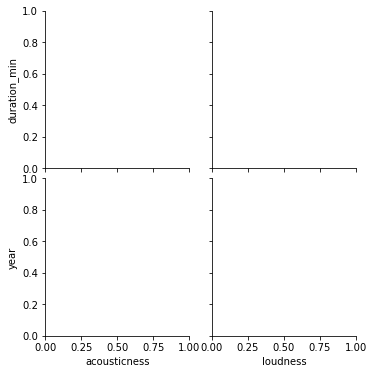

In [40]:
plt.figure( figsize=(2,2), dpi= 300)

data_grid = sns.PairGrid(trainData, hue='popularity', y_vars=[ 'duration_min', 'year'], x_vars=['acousticness', 'loudness'])

data_grid.map(plt.scatter)
data_grid.add_legend()